## **Import Dependencies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from glob import glob
from tqdm.auto import tqdm
import ee
import geemap
from shapely.geometry import box
from sklearn.model_selection import train_test_split
import spyndex

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = 'Times New Roman'

data_dir = r'D:\HALDER\GITHUB\MSM-Research\Landscape-Classification\datasets'
temp_dir = r'temp'

## **Intialize an EE Map Object**

In [2]:
# ee.Authenticate()
ee.Initialize(
    opt_url="https://earthengine-highvolume.googleapis.com",
    project='ee-geonextgis'
)

In [3]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## **Read the Datasets**

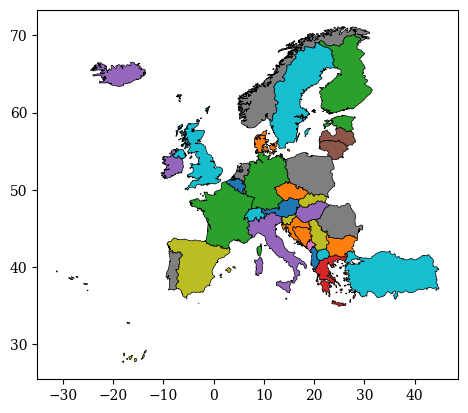

In [4]:
# Read the shapefile for Europe
world = gpd.read_file(os.path.join(data_dir, 'world-administrative-boundaries', 'world-administrative-boundaries.shp'))
world_ee = ee.FeatureCollection('projects/ee-geonextgis/assets/world_administrative_boundaries')
# Map.addLayer(world_ee.style(**{'fillColor': '00000000', 'width': 1, 'color': 'brown'}), {}, 'World Boundaries')

# Filter the countries belonging to Europe
europe = world[world['continent']=='Europe']
europe_country_names = europe['name'].unique()

# Specify the countries to remove
countries_to_remove = {'Russian Federation', 'Belarus', 'Ukraine', 'Moldova, Republic of', 'Svalbard and Jan Mayen Islands'}
europe_country_names = list(set(europe_country_names).difference(countries_to_remove))
europe_country_names.append('Turkey')
europe = world[world['name'].isin(europe_country_names)]
europe_ee = world_ee.filter(ee.Filter.inList('name', europe_country_names))
Map.addLayer(europe_ee.style(**{'fillColor': '00000000', 'width': 1, 'color': 'brown'}), {}, 'Europe Boundaries')
Map.centerObject(europe_ee, 4)

europe.plot(column='name', edgecolor='k', linewidth=0.5);

In [5]:
# Generate fishnet layers
fishnet = geemap.fishnet(europe_ee.geometry(), h_interval=1, v_interval=1, delta=1)
fishnet = fishnet.map(lambda f: f.set('Cell_ID', f.get('system:index')))
fishnet_gdf = geemap.ee_to_gdf(fishnet)[['Cell_ID', 'geometry']]
Map.addLayer(fishnet.style(**{'fillColor': '00000000', 'width': 1, 'color': 'blue'}), {}, 'Grids')
print(fishnet_gdf.shape)
fishnet_gdf.head()

(1097, 2)


,Cell_ID,geometry
0,0_13,"POLYGON ((-18.28903 27.6375, -17.28903 27.6375..."
1,0_14,"POLYGON ((-17.28903 27.6375, -16.28903 27.6375..."
2,0_15,"POLYGON ((-16.28903 27.6375, -15.28903 27.6375..."
3,0_16,"POLYGON ((-15.28903 27.6375, -14.28903 27.6375..."
4,0_17,"POLYGON ((-14.28903 27.6375, -13.28903 27.6375..."


In [6]:
# Calculate the area for each country
europe['area'] = (europe.to_crs(crs='EPSG:3857').area // 1e6).astype('int')
europe = europe[['name', 'area', 'geometry']]

# Calculate the area proportion
europe['area_proportion'] = ((europe['area'] / europe['area'].sum())).round(4)

# Calculate the number of samples per country
total_n_samples = 1e6 # total number of samples
europe['n_of_samples'] = (europe['area_proportion'] * total_n_samples).astype('int')

# Drop the columns where number of samples is 0
europe = europe[europe['n_of_samples']>0]
europe.sort_values(by='n_of_samples', ascending=False, inplace=True)

print(europe.shape)
europe.head()

(40, 5)


,name,area,geometry,area_proportion,n_of_samples
250,Sweden,2164148,"MULTIPOLYGON (((16.43722 56.21139, 16.42972 56...",0.1339,133900
26,Finland,1823829,"MULTIPOLYGON (((23.70583 59.92722, 23.64944 59...",0.1129,112900
204,Norway,1767226,"MULTIPOLYGON (((5.28778 59.21889, 5.25597 59.1...",0.1093,109300
27,Turkey,1296778,"MULTIPOLYGON (((25.82444 40.10026, 25.73167 40...",0.0802,80200
2,France,1162358,"MULTIPOLYGON (((9.4475 42.68305, 9.45014 42.63...",0.0719,71900


## **Sample Generation**

In [7]:
clc2018_path = os.path.join(data_dir, 'CLC_2018', 'DATA', 'U2018_CLC2018_V2020_20u1.gpkg')
layer_name = 'U2018_CLC2018_V2020_20u1'
europe_3035 = europe.to_crs(crs='EPSG:3035')

# Function to read the data for a country
def read_gpkg(data_path, layer_name, country_name):
    minx, miny, maxx, maxy = europe_3035[europe_3035['name']==country_name].geometry.bounds.T.values.flatten()
    bbox = box(minx, miny, maxx, maxy)
    data = gpd.read_file(data_path, layer=layer_name, bbox=bbox)
    data = data.to_crs('EPSG:4326')
    return data

# Function to generate stratified sample points
def get_stratified_sample(data, category, n_per_class, random_state):

    try:
        class_count = data['Code_18'].value_counts()
        valid_class = class_count[class_count>=n_per_class].index
        invalid_class = class_count[class_count<n_per_class].index

        stratified_sample_valid = data[data['Code_18'].isin(valid_class)].groupby(category, group_keys=False).apply(
            lambda x: x.sample(n=n_per_class, random_state=random_state, replace=False))
        
        stratified_sample_invalid = data[data['Code_18'].isin(invalid_class)].groupby(category, group_keys=False).apply(
            lambda x: x.sample(n=n_per_class, random_state=random_state, replace=True))\
            .drop_duplicates(subset=['ID'])

        stratified_sample = pd.concat((stratified_sample_valid, stratified_sample_invalid), axis=0, ignore_index=True)
        return stratified_sample
    
    except:
        print('Error: No data found.')
        return None

In [8]:
# # Apply the function for all the countries
# for country in tqdm(sorted(europe_country_names)):
#     print('*'*50)
#     print('Country:', country)

#     try:
#         data = read_gpkg(data_path=clc2018_path, layer_name=layer_name, country_name=country)

#         stratified_sample = get_stratified_sample(data=data, category='Code_18', n_per_class=200, random_state=42)

#         if stratified_sample is not None:
#             print('Shape:', stratified_sample.shape)
#             stratified_sample.geometry = stratified_sample.geometry.representative_point()
#             stratified_sample.drop(columns=['Remark'], inplace=True)

#             out_path = os.path.join(temp_dir, f'{country}_sample.shp')
#             stratified_sample.to_file(out_path)
#             print(f'File saved at {out_path}')

#     except:
#         continue

In [9]:
# # Merge all the shapefile into a single geodataframe
# file_paths = glob(os.path.join(temp_dir, '*sample.shp'))
# final_samples = pd.DataFrame()

# for path in tqdm(file_paths):
#     country = os.path.basename(path).split("_")[0]
#     gdf = gpd.read_file(path)
#     gdf['Country'] = country
#     gdf = gdf[['Code_18', 'Area_Ha', 'ID', 'Country', 'geometry']]
#     final_samples = pd.concat((final_samples, gdf), axis=0, ignore_index=True)

# print(final_samples.shape)
# final_samples.head()

In [10]:
# # Drop the class '999' and save the data
# final_samples = final_samples[~final_samples['Code_18'].isin(['999'])]
# print(final_samples.shape)
# final_samples.head()

In [11]:
# final_samples.to_file(os.path.join(data_dir, 'CLC_2018_Samples', 'CLC_2018_Samples.shp'))
final_samples = gpd.read_file(os.path.join(data_dir, 'CLC_2018_Samples', 'CLC_2018_Samples.shp'))
print(final_samples.shape)
final_samples.head()

(162769, 5)


,Code_18,Area_Ha,ID,Country,geometry
0,112,36.786987,EU_846772,Albania,POINT (19.68159 41.43333)
1,112,27.713340,EU_846779,Albania,POINT (19.52561 41.46623)
2,112,57.462388,EU_847544,Albania,POINT (21.17545 42.44417)
3,112,51.858726,EU_846098,Albania,POINT (19.39466 40.65666)
4,112,25.895365,EU_846048,Albania,POINT (20.61174 40.46888)


In [12]:
# Assign cell id to each final_samples
final_samples = gpd.sjoin(left_df=final_samples, right_df=fishnet_gdf, how='inner', predicate='intersects')
final_samples = final_samples[['Code_18', 'Area_Ha', 'ID', 'Country', 'Cell_ID', 'geometry']]
print(final_samples.shape)
final_samples.head()

(162637, 6)


,Code_18,Area_Ha,ID,Country,Cell_ID,geometry
0,112,36.786987,EU_846772,Albania,13_50,POINT (19.68159 41.43333)
1,112,27.713340,EU_846779,Albania,13_50,POINT (19.52561 41.46623)
2,112,57.462388,EU_847544,Albania,14_52,POINT (21.17545 42.44417)
3,112,51.858726,EU_846098,Albania,13_50,POINT (19.39466 40.65666)
4,112,25.895365,EU_846048,Albania,12_51,POINT (20.61174 40.46888)


## **Extract Values from RS Data**

### **Prepare the Seasonal Sentinel Image Datasets**

In [13]:
# Function to remove clouds from Sentine-2 imagery
def maskS2CloudsAndShadow(image, cloud_perc=10):

    cloudProb = image.select("MSK_CLDPRB")
    cloud = cloudProb.lt(cloud_perc)
    scl = image.select("SCL")
    saturated = scl.eq(1)
    cloudShadow = scl.eq(3)
    cirrus = scl.eq(10)

    # Create a mask
    mask = cloud.And(saturated.neq(1)).And(cloudShadow.neq(1)).And(cirrus.neq(1))

    return image.updateMask(mask)

# Function to perform edge masking on Sentinel-1 images
def edgeMasking(image, min_thresh=30, max_thresh=45):

    angle = image.select("angle")
    mask = angle.gt(min_thresh).And(angle.lt(max_thresh))

    return image.updateMask(mask)

In [14]:
# Function to prepare Sentinel 1 and 2 composite
def prepareSentinelComposite(region,
                             s1_band_names,
                             s2_band_names,
                             start_year,
                             end_year,
                             start_month,
                             end_month):

    # Read the Sentinel-2 and Sentinel-1 images from the Earth Engine
    sentinel_2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
        .filterBounds(region.bounds())\
        .filter(ee.Filter.calendarRange(start_year, end_year, 'year'))\
        .filter(ee.Filter.calendarRange(start_month, end_month, 'month'))\
        .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 10)\
        .map(maskS2CloudsAndShadow)\
        .select(s2_band_names)\
        .median()\
        .clip(region.bounds())

    # Prepare Vegetation Indices
    ndvi = sentinel_2.normalizedDifference(['B8', 'B4']).rename('NDVI')
    savi = sentinel_2.expression(
        '((NIR - RED) / (NIR + RED + L)) * (1 + L)',
        {
            'NIR': sentinel_2.select('B8'),
            'RED': sentinel_2.select('B4'),
            'L': 0.5
        }
    ).rename('SAVI')

    sentinel_1 = ee.ImageCollection("COPERNICUS/S1_GRD")\
        .filterBounds(region.bounds())\
        .filter(ee.Filter.calendarRange(start_year, end_year, 'year'))\
        .filter(ee.Filter.calendarRange(start_month, end_month, 'month'))\
        .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))\
        .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VH"))\
        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
        .filter(ee.Filter.eq("orbitProperties_pass", "DESCENDING"))\
        .map(edgeMasking)\
        .select(s1_band_names)\
        .mean()\
        .clip(region.bounds())

    # Combine both the Image
    sentinel_combined = sentinel_2.addBands(ndvi)\
                                  .addBands(savi)\
                                  .addBands(sentinel_1).setDefaultProjection('EPSG:3857', None, 10)\

    return sentinel_combined

In [15]:
# Function to prepare topographic variables (e.g., elevation, slope)
def prepareTopographicFeatures(region):

    # Read the Copernicus Digital Elevation Model (Glo-30 DEM)
    glo30 = ee.ImageCollection("projects/sat-io/open-datasets/GLO-30").mosaic()\
              .setDefaultProjection('EPSG:3857', None, 30)\
              .select('b1')

    # Clip the elevation
    elevation = glo30.clip(region.bounds()).rename('Elevation')

    # Derive the slope
    slope = ee.Terrain.slope(elevation).rename('Slope')

    return elevation.addBands(slope)

In [16]:
## Example usage
# Define the Sentinel-2 and Sentinel-1 band names
s2_band_names = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12']
s1_band_names = ["VH", "VV"]

# Define the start, end month, and year
start_year = 2017
end_year = 2019
start_month = 12
end_month = 2

test_region = world_ee.filter(ee.Filter.eq('name', 'Albania')).geometry()

test_sentinel_composite = prepareSentinelComposite(
    region=test_region,
    s1_band_names=s1_band_names,
    s2_band_names=s2_band_names,
    start_year=start_year,
    end_year=end_year,
    start_month=start_month,
    end_month=end_month
)

test_topographic_features = prepareTopographicFeatures(test_region)

Map.addLayer(test_sentinel_composite, {"min": 0, "max": 4000, "bands": ["B8", "B4", "B3"]}, "Test Sentinel Image", False)
Map.addLayer(test_topographic_features, {'min': 0, 'max': 90, 'bands': ['Slope']}, 'Test Topographic Features', False)

### **Data Extraction**

In [17]:
# Define the Sentinel-2 and Sentinel-1 band names
s2_band_names = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12']
s1_band_names = ["VH", "VV"]

# Define the start, end month of four seasons in a dictionary
season_dict = {
    'Summer': [6, 8], # June to August
    'Autumn': [9, 11], # September to November
    'Winter': [12, 2], # December to February
    'Spring': [3, 5] # March to May
}

In [18]:
def dataframe_batches(df, batch_size):
    """Yield successive batches from a DataFrame."""
    for start in range(0, len(df), batch_size):
        yield df.iloc[start:start + batch_size]

In [ ]:
# Download the data for each country
for country in tqdm(sorted(final_samples['Country'].unique())):
    print('*'*50)
    print('Country:', country)
    region = europe_ee.filter(ee.Filter.eq('name', country)).bounds()
    region_samples = final_samples[final_samples['Country']==country]

    region_final_image = ee.Image()

    for season, (start_month, end_month) in season_dict.items():
        region_sentinel_composite = prepareSentinelComposite(
            region=region,
            s1_band_names=s1_band_names,
            s2_band_names=s2_band_names,
            start_year=start_year,
            end_year=end_year,
            start_month=start_month,
            end_month=end_month
        )

        band_names = region_sentinel_composite.bandNames().getInfo()
        new_band_names = [f'{name}_{season}' for name in band_names]
        region_sentinel_composite = region_sentinel_composite.rename(new_band_names)
        region_final_image = region_final_image.addBands(region_sentinel_composite)

    region_topographic_features = prepareTopographicFeatures(region)
    region_final_image = region_final_image.addBands(region_topographic_features)

    # Batch size
    batch_size = 2000

    # Process in batches
    for i, batch in enumerate(dataframe_batches(region_samples, batch_size)):
        batch_ee = geemap.gdf_to_ee(batch)

        result = region_final_image.reduceRegions(
            collection=batch_ee,
            reducer=ee.Reducer.first(),
            scale=10,
            crs='EPSG:4326',
            tileScale=16
        )
        
        try:
            result_df = geemap.ee_to_df(result)

            out_path = os.path.join(temp_dir, f'{country}_samples_batch_{i+1}.csv')
            result_df.to_csv(out_path, index=False)
            print(f'Batch {i+1} saved to {out_path}')

        except:
            print(f'Batch {i+1} Error!')
            continue

  0%|          | 0/40 [00:00<?, ?it/s]

**************************************************
Country: Albania


In [26]:
# # Merge all the files into a single dataframe
# file_paths = glob(os.path.join(temp_dir, '*.csv'))
# sample_df = pd.DataFrame()

# for path in tqdm(file_paths):
#     df = pd.read_csv(path)
#     sample_df = pd.concat((sample_df, df), axis=0, ignore_index=True)

# print(sample_df.shape)
# sample_df.head()   

In [27]:
# # Fix the column order
# col_order = ['Code_18', 'Area_Ha', 'ID', 'Country', 'Cell_ID']
# band_names = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'VH', 'VV']

# for var in band_names:
#     var_bands = list(sample_df.filter(like=var).columns)
#     col_order.extend(var_bands)

# sample_df = sample_df[col_order]

# # Drop the NaN values
# sample_df.dropna(inplace=True)
# print(sample_df.shape)
# sample_df.head()   

In [134]:
# Save the data
# sample_df.to_csv(os.path.join(data_dir, 'CLC_2018_Samples', 'CLC_2018_Samples.csv'), index=False)
final_df = pd.read_csv(os.path.join(data_dir, 'CLC_2018_Samples', 'CLC_2018_Samples.csv'))
print(final_df.shape)
final_df.head()   

(140008, 49)


,Code_18,Area_Ha,ID,Country,Cell_ID,B2_Autumn,B2_Spring,B2_Summer,B2_Winter,B3_Autumn,...,B12_Summer,B12_Winter,VH_Autumn,VH_Spring,VH_Summer,VH_Winter,VV_Autumn,VV_Spring,VV_Summer,VV_Winter
0,112,36.786987,EU_846772,Albania,13_50,362.0,556.0,548.5,376.0,599.0,...,2291.0,1336.0,-13.738744,-13.802746,-14.616246,-13.959236,-8.736215,-8.044366,-8.433759,-8.155536
1,112,27.713340,EU_846779,Albania,13_50,1094.0,1407.5,1410.0,764.0,1364.0,...,2595.0,1439.0,-15.582236,-14.800288,-15.784538,-12.763657,-9.937074,-8.790976,-10.213699,-7.652420
2,112,51.858726,EU_846098,Albania,13_50,732.5,1072.0,981.5,792.0,1029.0,...,1711.0,1733.0,-17.135412,-17.215439,-15.656101,-17.312225,-11.206528,-10.530737,-10.008188,-10.752580
3,112,25.895365,EU_846048,Albania,12_51,420.0,584.0,512.0,683.0,625.0,...,1769.0,1524.0,-13.204691,-13.162791,-13.200306,-13.169536,-5.321580,-6.334345,-5.713282,-6.482810
4,112,28.108834,EU_631891,Albania,12_51,509.0,411.5,567.0,404.5,721.5,...,1970.0,1543.0,-18.389660,-17.886069,-17.319378,-17.742781,-11.155903,-10.946455,-11.786337,-10.273939


In [135]:
sample_df = final_df[['Code_18', 'Area_Ha', 'ID', 'Country', 'Cell_ID']]
seasons = ['Summer', 'Autumn', 'Winter', 'Spring']

for season in seasons:
    season_cols_s2 = [f'{col}_{season}' for col in s2_band_names]
    season_cols_s1 = [f'{col}_{season}' for col in s1_band_names]

    season_df_s2 = final_df[season_cols_s2]
    season_df_s1 = final_df[season_cols_s1]

    mask = season_df_s2 < 1
    season_df_s2[mask] = 1

    sample_df = pd.concat((sample_df, season_df_s2, season_df_s1), axis=1)

print(sample_df.shape)
sample_df.head()

(140008, 49)


,Code_18,Area_Ha,ID,Country,Cell_ID,B2_Summer,B3_Summer,B4_Summer,B5_Summer,B6_Summer,...,B3_Spring,B4_Spring,B5_Spring,B6_Spring,B7_Spring,B8_Spring,B11_Spring,B12_Spring,VH_Spring,VV_Spring
0,112,36.786987,EU_846772,Albania,13_50,548.5,899.0,829.0,1512.5,2386.0,...,881.5,925.5,1480.5,2258.5,2567.5,2742.0,2611.5,2105.5,-13.802746,-8.044366
1,112,27.713340,EU_846779,Albania,13_50,1410.0,1670.0,1839.0,2065.0,2332.5,...,1692.5,1892.0,1907.5,2086.5,2210.5,2608.5,2731.0,2374.0,-14.800288,-8.790976
2,112,51.858726,EU_846098,Albania,13_50,981.5,1325.0,1237.0,1573.5,2998.5,...,1389.0,1362.0,1641.0,3357.0,3837.0,3880.0,2502.0,1575.0,-17.215439,-10.530737
3,112,25.895365,EU_846048,Albania,12_51,512.0,736.0,796.0,1285.0,2738.0,...,726.0,1000.0,1265.0,1375.0,1523.0,1570.0,2454.0,1999.0,-13.162791,-6.334345
4,112,28.108834,EU_631891,Albania,12_51,567.0,840.0,982.0,1419.0,2131.0,...,816.5,501.0,1390.5,3266.5,3721.5,4118.0,2402.5,1390.5,-17.886069,-10.946455


## **Calculate Different Remote Sensing Indices**

In [172]:
# Function to calculate pearson correlation across different feature combinations
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

# Function to clip outliers
def clip_outliers(df, lower=0.01, upper=0.99):
    """
    Clip values below the 1st percentile and above the 99th percentile
    to the 1st and 99th percentile values, respectively.
    """
    return df.apply(lambda x: x.clip(lower=x.quantile(lower), upper=x.quantile(upper)), axis=0)

In [181]:
final_info = sample_df[['Code_18', 'Area_Ha', 'ID', 'Country', 'Cell_ID']]
seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
corr_features_all = []

for season in seasons:
    season_cols_s2 = [f'{col}_{season}' for col in s2_band_names]
    season_cols_s1 = [f'{col}_{season}' for col in s1_band_names]

    season_df_s2 = sample_df[season_cols_s2] * 0.0001
    season_df_s1 = sample_df[season_cols_s1]

    # Sample band values (arrays or scalars are supported)
    col_params = {
        'B': season_df_s2[f'B2_{season}'], # Blue
        'G': season_df_s2[f'B3_{season}'], # Green
        'R': season_df_s2[f'B4_{season}'], # Red
        'RE1': season_df_s2[f'B5_{season}'], # Red Edge 1
        'RE2': season_df_s2[f'B6_{season}'], # Red Edge 2
        'RE3': season_df_s2[f'B7_{season}'], # Red Edge 3
        'N': season_df_s2[f'B8_{season}'], # NIR
        'S1': season_df_s2[f'B11_{season}'], # SWIR 1
        'S2': season_df_s2[f'B12_{season}'], # SWIR 2
        'VH': season_df_s1[f'VH_{season}'], # VH
        'VV': season_df_s1[f'VV_{season}'] # VV
    }

    col_params.update({
        'L': 0.5,        # Used in SAVI, IBI, GSAVI, etc.
        'g': 2.5,        # Used in EVI, EVI2,
        'C1': 6,         # EVI,
        'C2': 7.5,       # EVI
        'gamma': 1.0,    # ARVI, IAVI
        'alpha': 0.1,    # WDRVI, NDPI
        'sla': 1.0,      # TSAVI, ATSAVI, WDVI
        'kNN': 0.3,      # For kernel-based indices like kNDVI
        'A': 0.1,        # Some vegetation indices
        'epsilon': 0.95, # EBI
        'PAR': 0.2       # Photosynthetically active radiation
    })

    # Get all valid index names
    index_names = list(spyndex.indices.keys())

    # Store results
    results = {}

    # Loop and compute only indices that can be calculated with the given params
    for index in index_names:
        try:
            result = spyndex.computeIndex(index=index, params=col_params)
            results[f'{index}_{season}'] = result
        except Exception as e:
            # Optionally print skipped index
            print(f"Skipped {index}: {e}")

    # Convert to DataFrame
    indices_df = pd.DataFrame(results)

    # Clip outliers in indices
    indices_df = clip_outliers(indices_df)

    # Remove highly correlated features
    corr_features = correlation(indices_df, threshold=0.90)
    corr_features = list(corr_features)
    print('Number of highly correlated features:', len(corr_features))
    corr_features_all.extend(list(corr_features))

    final_info = pd.concat((final_info, season_df_s2, season_df_s1, indices_df), axis=1)

print(final_info.shape)
final_info.head()

Skipped ATSAVI: 'slb' is missing in the parameters for ATSAVI computation!
Skipped BAIS2: 'N2' is missing in the parameters for BAIS2 computation!
Skipped CCI: 'G1' is missing in the parameters for CCI computation!
Skipped CSIT: 'T' is missing in the parameters for CSIT computation!
Skipped DBI: 'T1' is missing in the parameters for DBI computation!
Skipped DVIplus: 'lambdaN' is missing in the parameters for DVIplus computation!
Skipped DpRVIHH: 'HV' is missing in the parameters for DpRVIHH computation!
Skipped EBBI: 'T' is missing in the parameters for EBBI computation!
Skipped FAI: 'lambdaN' is missing in the parameters for FAI computation!
Skipped GDVI: 'nexp' is missing in the parameters for GDVI computation!
Skipped MBWI: 'omega' is missing in the parameters for MBWI computation!
Skipped NBLI: 'T' is missing in the parameters for NBLI computation!
Skipped NBLIOLI: 'T1' is missing in the parameters for NBLIOLI computation!
Skipped NBRT1: 'T' is missing in the parameters for NBRT1 c

,Code_18,Area_Ha,ID,Country,Cell_ID,B2_Summer,B3_Summer,B4_Summer,B5_Summer,B6_Summer,...,WI2015_Spring,WRI_Spring,bNIRv_Spring,mND705_Spring,mSR705_Spring,sNIRvLSWI_Spring,sNIRvNDPI_Spring,sNIRvNDVILSWIP_Spring,sNIRvNDVILSWIS_Spring,sNIRvSWIR_Spring
0,112,36.786987,EU_846772,Albania,13_50,0.05485,0.0899,0.0829,0.15125,0.23860,...,-28.82310,0.337536,0.181747,0.284045,0.386221,0.036004,0.043743,0.017833,0.171814,0.091595
1,112,27.713340,EU_846779,Albania,13_50,0.14100,0.1670,0.1839,0.20650,0.23325,...,-16.17465,0.671318,0.078008,0.059786,0.352017,0.012277,0.014945,0.001955,0.053805,0.007876
2,112,51.858726,EU_846098,Albania,13_50,0.09815,0.1325,0.1237,0.15735,0.29985,...,-23.72060,0.431056,0.220013,0.429215,0.540969,0.163949,0.166112,0.078753,0.350325,0.160424
3,112,25.895365,EU_846048,Albania,12_51,0.05120,0.0736,0.0796,0.12850,0.27380,...,-21.79090,0.428926,0.071867,0.067073,0.157895,-0.018872,-0.014894,-0.004186,0.015949,0.009009
4,112,28.108834,EU_631891,Albania,12_51,0.05670,0.0840,0.0982,0.14190,0.21310,...,-33.67695,0.202055,0.336977,0.512989,0.531232,0.203900,0.214006,0.159668,0.526368,0.292967


In [213]:
# Assess the correleated features
corr_features_df = pd.DataFrame(
  {
   'index': [i.split('_')[0] for i in corr_features_all],
   'season': [i.split('_')[1] for i in corr_features_all]
  }
)
print(corr_features_df.shape)
corr_count = corr_features_df['index'].value_counts()
corr_features_final = corr_count[corr_count>2].index 
print('Number of final highly correlated features:', len(corr_features_final))
corr_features_final = [f'{f}_{season}' for f in corr_features_final for season in seasons]
corr_features_df.head()

(570, 2)
Number of final highly correlated features: 136


,index,season
0,EVIv,Summer
1,WRI,Summer
2,ARVI,Summer
3,VHVVR,Summer
4,NDREI,Summer


In [215]:
# Drop the correlated features from the dataframe
final_info = final_info.drop(columns=corr_features_final)
print(final_info.shape)
final_info.head()

(140008, 297)


,Code_18,Area_Ha,ID,Country,Cell_ID,B2_Summer,B3_Summer,B4_Summer,B5_Summer,B6_Summer,...,TCARI_Spring,TCARIOSAVI_Spring,TCARIOSAVI705_Spring,VARI700_Spring,VDDPI_Spring,VHVVD_Spring,VIBI_Spring,mND705_Spring,mSR705_Spring,sNIRvLSWI_Spring
0,112,36.786987,EU_846772,Albania,13_50,0.05485,0.0899,0.0829,0.15125,0.23860,...,0.109008,0.272501,0.635153,0.151133,2.715828,-5.758380,1.051764,0.284045,0.386221,0.036004
1,112,27.713340,EU_846779,Albania,13_50,0.14100,0.1670,0.1839,0.20650,0.23325,...,-0.008356,-0.061330,0.750077,-0.127554,2.683577,-6.009312,0.874045,0.059786,0.352017,0.012277
2,112,51.858726,EU_846098,Albania,13_50,0.09815,0.1325,0.1237,0.15735,0.29985,...,0.065483,0.153390,0.905705,0.037661,2.634780,-6.684702,1.816544,0.429215,0.540969,0.163949
3,112,25.895365,EU_846048,Albania,12_51,0.05120,0.0736,0.0796,0.12850,0.27380,...,0.038590,0.243376,-0.309895,-0.014509,3.078004,-6.828446,0.502387,0.067073,0.157895,-0.018872
4,112,28.108834,EU_631891,Albania,12_51,0.05670,0.0840,0.0982,0.14190,0.21310,...,0.171264,0.253851,0.625292,0.548727,2.633960,-6.939613,1.505971,0.512989,0.531232,0.203900


In [ ]:
# Save the data
# final_info.to_csv(os.path.join(data_dir, 'CLC_2018_Samples', 'CLC_2018_Samples_v2.csv'), index=False)
final_df = pd.read_csv(os.path.join(data_dir, 'CLC_2018_Samples', 'CLC_2018_Samples_v2.csv'))
print(final_df.shape)
final_df.head()   

(140008, 297)


,Code_18,Area_Ha,ID,Country,Cell_ID,B2_Summer,B3_Summer,B4_Summer,B5_Summer,B6_Summer,...,TCARI_Spring,TCARIOSAVI_Spring,TCARIOSAVI705_Spring,VARI700_Spring,VDDPI_Spring,VHVVD_Spring,VIBI_Spring,mND705_Spring,mSR705_Spring,sNIRvLSWI_Spring
0,112,36.786987,EU_846772,Albania,13_50,0.05485,0.0899,0.0829,0.15125,0.23860,...,0.109008,0.272501,0.635153,0.151133,2.715828,-5.758380,1.051764,0.284045,0.386221,0.036004
1,112,27.713340,EU_846779,Albania,13_50,0.14100,0.1670,0.1839,0.20650,0.23325,...,-0.008356,-0.061330,0.750077,-0.127554,2.683577,-6.009312,0.874045,0.059786,0.352017,0.012277
2,112,51.858726,EU_846098,Albania,13_50,0.09815,0.1325,0.1237,0.15735,0.29985,...,0.065483,0.153390,0.905705,0.037661,2.634780,-6.684702,1.816544,0.429215,0.540969,0.163949
3,112,25.895365,EU_846048,Albania,12_51,0.05120,0.0736,0.0796,0.12850,0.27380,...,0.038590,0.243376,-0.309895,-0.014509,3.078004,-6.828446,0.502387,0.067073,0.157895,-0.018872
4,112,28.108834,EU_631891,Albania,12_51,0.05670,0.0840,0.0982,0.14190,0.21310,...,0.171264,0.253851,0.625292,0.548727,2.633960,-6.939613,1.505971,0.512989,0.531232,0.203900
